In [1]:
import pyemd
import os
import copy
import numpy as np
import networkx as nx
import subprocess as sp
import concurrent.futures
from random import shuffle
from datetime import datetime
import numpy as np
# import igraph
import networkx as nx
import concurrent.futures
from functools import partial
from scipy.linalg import toeplitz
import pickle
import itertools
from random import shuffle
from collections import OrderedDict
import json
from pprint import pprint
import codecs
import matplotlib.pyplot as plt

In [2]:
def emd(x, y, distance_scaling=1.0):
    support_size = max(len(x), len(y))
    d_mat = toeplitz(range(support_size)).astype(np.float)
    distance_mat = d_mat / distance_scaling

    # convert histogram values x and y to float, and make them equal len
    x = x.astype(np.float)
    y = y.astype(np.float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    emd = pyemd.emd(x, y, distance_mat)
    return emd


def l2(x, y):
    dist = np.linalg.norm(x - y, 2)
    return dist


def emd(x, y, sigma=1.0, distance_scaling=1.0):
    ''' EMD
    Args:
      x, y: 1D pmf of two distributions with the same support
      sigma: standard deviation
    '''
    support_size = max(len(x), len(y))
    d_mat = toeplitz(range(support_size)).astype(np.float)
    distance_mat = d_mat / distance_scaling

    # convert histogram values x and y to float, and make them equal len
    x = x.astype(np.float)
    y = y.astype(np.float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    return np.abs(pyemd.emd(x, y, distance_mat))


def gaussian_emd(x, y, sigma=1.0, distance_scaling=1.0):
    ''' Gaussian kernel with squared distance in exponential term replaced by EMD
    Args:
      x, y: 1D pmf of two distributions with the same support
      sigma: standard deviation
    '''
    support_size = max(len(x), len(y))
    d_mat = toeplitz(range(support_size)).astype(np.float)
    distance_mat = d_mat / distance_scaling

    # convert histogram values x and y to float, and make them equal len
    x = x.astype(np.float)
    y = y.astype(np.float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    emd = pyemd.emd(x, y, distance_mat)
    return np.exp(-emd * emd / (2 * sigma * sigma))


def gaussian(x, y, sigma=1.0):  
    support_size = max(len(x), len(y))
    # convert histogram values x and y to float, and make them equal len
    x = x.astype(np.float)
    y = y.astype(np.float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    dist = np.linalg.norm(x - y, 2)
    return np.exp(-dist * dist / (2 * sigma * sigma))


def gaussian_tv(x, y, sigma=1.0):  
    support_size = max(len(x), len(y))
    # convert histogram values x and y to float, and make them equal len
    x = x.astype(np.float)
    y = y.astype(np.float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    dist = np.abs(x - y).sum() / 2.0
    return np.exp(-dist * dist / (2 * sigma * sigma))


def kernel_parallel_unpacked(x, samples2, kernel):
    d = 0
    for s2 in samples2:
        d += kernel(x, s2)
    return d


def kernel_parallel_worker(t):
    return kernel_parallel_unpacked(*t)


def disc(samples1, samples2, kernel, is_parallel=True, *args, **kwargs):
    ''' Discrepancy between 2 samples '''
    d = 0

    if not is_parallel:
        for s1 in samples1:
            for s2 in samples2:
                d += kernel(s1, s2, *args, **kwargs)
    else:
    # with concurrent.futures.ProcessPoolExecutor() as executor:
    #   for dist in executor.map(kernel_parallel_worker, [
    #       (s1, samples2, partial(kernel, *args, **kwargs)) for s1 in samples1
    #   ]):
    #     d += dist

        with concurrent.futures.ThreadPoolExecutor() as executor:
            for dist in executor.map(kernel_parallel_worker, [
              (s1, samples2, partial(kernel, *args, **kwargs)) for s1 in samples1
            ]):
                d += dist

    d /= len(samples1) * len(samples2)
    return d


def compute_mmd(samples1, samples2, kernel, is_hist=True, *args, **kwargs):
    ''' MMD between two samples '''
    # normalize histograms into pmf  
    if is_hist:
        samples1 = [s1 / np.sum(s1) for s1 in samples1]
        samples2 = [s2 / np.sum(s2) for s2 in samples2]
    # print('===============================')
    # print('s1: ', disc(samples1, samples1, kernel, *args, **kwargs))
    # print('--------------------------')
    # print('s2: ', disc(samples2, samples2, kernel, *args, **kwargs))
    # print('--------------------------')
    # print('cross: ', disc(samples1, samples2, kernel, *args, **kwargs))
    # print('===============================')
    return disc(samples1, samples1, kernel, *args, **kwargs) + \
          disc(samples2, samples2, kernel, *args, **kwargs) - \
          2 * disc(samples1, samples2, kernel, *args, **kwargs)


def compute_emd(samples1, samples2, kernel, is_hist=True, *args, **kwargs):
    ''' EMD between average of two samples '''
    # normalize histograms into pmf
    if is_hist:
        samples1 = [np.mean(samples1)]
        samples2 = [np.mean(samples2)]
    # print('===============================')
    # print('s1: ', disc(samples1, samples1, kernel, *args, **kwargs))
    # print('--------------------------')
    # print('s2: ', disc(samples2, samples2, kernel, *args, **kwargs))
    # print('--------------------------')
    # print('cross: ', disc(samples1, samples2, kernel, *args, **kwargs))
    # print('===============================')
    return disc(samples1, samples2, kernel, *args,
              **kwargs), [samples1[0], samples2[0]]

In [3]:
def edge_list_reindexed(G):
    idx = 0
    id2idx = dict()
    for u in G.nodes():
        id2idx[str(u)] = idx
        idx += 1

    edges = []
    for (u, v) in G.edges():
        edges.append((id2idx[str(u)], id2idx[str(v)]))
    return edges

def orca(graph):
    tmp_fname = 'orca_tmp.txt'
    f = open(tmp_fname, 'w')
    f.write(str(graph.number_of_nodes()) + ' ' + str(graph.number_of_edges()) + '\n')
    for (u, v) in edge_list_reindexed(graph):
        f.write(str(u) + ' ' + str(v) + '\n')
    f.close()

    output = sp.check_output(['orca', 'node', '4', 'orca_tmp.txt', 'std'])
    output = output.decode('utf8').strip()

    idx = output.find(COUNT_START_STR) + len(COUNT_START_STR)
    output = output[idx:]
    node_orbit_counts = np.array([
      list(map(int,
               node_cnts.strip().split(' ')))
      for node_cnts in output.strip('\n').split('\n')
    ])

    try:
        os.remove(tmp_fname)
    except OSError:
        pass

    return node_orbit_counts

In [4]:
def find_nearest_idx(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

In [5]:
PRINT_TIME = False

def clustering_worker(param):
    G, bins = param
    if nx.is_directed(G):
        G = G.to_undirected()
    clustering_coeffs_list = list(nx.clustering(G).values())
    hist, _ = np.histogram(clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
    return hist


def clustering_stats(graph_ref_list,
                     graph_pred_list,
                     bins=100,
                     is_parallel=True):
    sample_ref = []
    sample_pred = []
    graph_pred_list_remove_empty = [
      G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    prev = datetime.now()
    if is_parallel:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for clustering_hist in executor.map(clustering_worker,
                                          [(G, bins) for G in graph_ref_list]):
                sample_ref.append(clustering_hist)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for clustering_hist in executor.map(
                clustering_worker, [(G, bins) for G in graph_pred_list_remove_empty]):
                sample_pred.append(clustering_hist)

    # with concurrent.futures.ProcessPoolExecutor() as executor:
    #   for clustering_hist in executor.map(clustering_worker,
    #                                       [(G, bins) for G in graph_ref_list]):
    #     sample_ref.append(clustering_hist)
    # with concurrent.futures.ProcessPoolExecutor() as executor:
    #   for clustering_hist in executor.map(
    #       clustering_worker, [(G, bins) for G in graph_pred_list_remove_empty]):
    #     sample_pred.append(clustering_hist)

    # check non-zero elements in hist
    #total = 0
    #for i in range(len(sample_pred)):
    #    nz = np.nonzero(sample_pred[i])[0].shape[0]
    #    total += nz
    #print(total)
    else:
        for i in range(len(graph_ref_list)):
            clustering_coeffs_list = list(nx.clustering(graph_ref_list[i]).values())
            hist, _ = np.histogram(clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
            sample_ref.append(hist)

        for i in range(len(graph_pred_list_remove_empty)):
            clustering_coeffs_list = list(nx.clustering(graph_pred_list_remove_empty[i]).values())
            hist, _ = np.histogram(clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
            sample_pred.append(hist)

#     mmd_dist = compute_mmd(
#         sample_ref,
#         sample_pred,
#         kernel=gaussian_emd,
#         sigma=1.0 / 10,
#         distance_scaling=bins)

    mmd_dist = compute_mmd(
      sample_ref,
      sample_pred,
      kernel=gaussian_tv,
      sigma=1.0 / 10)

    elapsed = datetime.now() - prev
    if PRINT_TIME:
        print('Time computing clustering mmd: ', elapsed)
    return mmd_dist


# maps motif/orbit name string to its corresponding list of indices from orca output
motif_to_indices = {
    '3path': [1, 2],
    '4cycle': [8],
}
COUNT_START_STR = 'orbit counts: \n'

In [127]:
def degree_worker(G, bins=20):
    return np.array(nx.degree_histogram(G.to_undirected()))
    # return np.histogram([d for i,d in G.to_undirected().degree], bins=bins, density=False)

def directed_degree_worker(G, bins=20):
    if not nx.is_directed(G):
        G = G.to_directed()
    in_hist, _ = np.histogram([d for i,d in G.in_degree], bins=bins, density=False)
    out_hist, _ = np.histogram([d for i,d in G.out_degree], bins=bins, density=False)
    return in_hist, out_hist


def degree_stats(graph_ref_list, graph_pred_list, is_parallel=True):
    ''' Compute the distance between the degree distributions of two unordered sets of graphs.
    Args:
      graph_ref_list, graph_target_list: two lists of networkx graphs to be evaluated
    '''
    sample_ref = []
    sample_pred = []
    # in case an empty graph is generated
    graph_pred_list_remove_empty = [
      G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    prev = datetime.now()
    if is_parallel:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for deg_hist in executor.map(degree_worker, graph_ref_list):
                sample_ref.append(deg_hist)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for deg_hist in executor.map(degree_worker, graph_pred_list_remove_empty):
                sample_pred.append(deg_hist)

    # with concurrent.futures.ProcessPoolExecutor() as executor:
    #   for deg_hist in executor.map(degree_worker, graph_ref_list):
    #     sample_ref.append(deg_hist)
    # with concurrent.futures.ProcessPoolExecutor() as executor:
    #   for deg_hist in executor.map(degree_worker, graph_pred_list_remove_empty):
    #     sample_pred.append(deg_hist)
    else:
        for i in range(len(graph_ref_list)):
            degree_temp = np.array(nx.degree_histogram(graph_ref_list[i]))
            sample_ref.append(degree_temp)
        for i in range(len(graph_pred_list_remove_empty)):
            degree_temp = np.array(nx.degree_histogram(graph_pred_list_remove_empty[i]))
            sample_pred.append(degree_temp)
        # print(len(sample_ref), len(sample_pred))

    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd)
    mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian)

    elapsed = datetime.now() - prev
    if PRINT_TIME:
        print('Time computing degree mmd: ', elapsed)
    return mmd_dist

def directed_degree_stats(graph_ref_list, graph_pred_list, bins=10, is_parallel=True):
    ''' Compute the distance between the degree distributions of two unordered sets of graphs.
    Args:
      graph_ref_list, graph_target_list: two lists of networkx graphs to be evaluated
    '''
    sample_ref_in = []
    sample_pred_in = []
    sample_ref_out = []
    sample_pred_out = []
    # in case an empty graph is generated
    graph_pred_list_remove_empty = [
      G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    prev = datetime.now()
    if is_parallel:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for in_deg_hist, out_deg_hist in executor.map(directed_degree_worker, graph_ref_list):
                sample_ref_in.append(in_deg_hist)
                sample_ref_out.append(out_deg_hist)
        with concurrent.futures.ThreadPoolExecutor() as executor:
            for in_deg_hist, out_deg_hist in executor.map(directed_degree_worker, graph_pred_list_remove_empty):
                sample_pred_in.append(in_deg_hist)
                sample_pred_out.append(out_deg_hist)

    # with concurrent.futures.ProcessPoolExecutor() as executor:
    #   for deg_hist in executor.map(degree_worker, graph_ref_list):
    #     sample_ref.append(deg_hist)
    # with concurrent.futures.ProcessPoolExecutor() as executor:
    #   for deg_hist in executor.map(degree_worker, graph_pred_list_remove_empty):
    #     sample_pred.append(deg_hist)
    else:
        print("pick parallel execution")
#         for i in range(len(graph_ref_list)):
#             degree_temp = np.array(nx.degree_histogram(graph_ref_list[i]))
#             sample_ref.append(degree_temp)
#         for i in range(len(graph_pred_list_remove_empty)):
#             degree_temp = np.array(nx.degree_histogram(graph_pred_list_remove_empty[i]))
#             sample_pred.append(degree_temp)
        # print(len(sample_ref), len(sample_pred))

    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd)
    mmd_dist_in = compute_mmd(sample_ref_in, sample_pred_in, kernel=gaussian_tv)
    mmd_dist_out = compute_mmd(sample_ref_out, sample_pred_out, kernel=gaussian_tv)

    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian)

    return mmd_dist_in, mmd_dist_out

In [7]:
def edge_flow_dist_stats(graph_ref_list, graph_pred_list, bins=100):
    ''' Compute the distance between the flow distributions of two unordered sets of graphs.
    Args:
      graph_ref_list, graph_target_list: two lists of networkx graphs to be evaluated
    '''
    sample_ref = []
    sample_pred = []
    # in case an empty graph is generated
    graph_pred_list_remove_empty = [
      G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    
    for i in range(len(graph_ref_list)):
        flow_dist_list = list(nx.get_edge_attributes(graph_ref_list[i],'weight').values())
        hist, _ = np.histogram(flow_dist_list, bins=bins, density=False)
        sample_ref.append(hist)

    for i in range(len(graph_pred_list_remove_empty)):
        flow_dist_list = list(nx.get_edge_attributes(graph_pred_list_remove_empty[i],'weight').values())
        hist, _ = np.histogram(flow_dist_list, bins=bins, density=False)
        sample_pred.append(hist)
    # print(len(sample_ref), len(sample_pred))

    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd)
    mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian)

    return mmd_dist


def node_flow_dist_stats(graph_ref_list, graph_pred_list, bins=100):
    ''' Compute the distance between the flow distributions of two unordered sets of graphs.
    Args:
      graph_ref_list, graph_target_list: two lists of networkx graphs to be evaluated
    '''
    sample_ref = []
    sample_pred = []
    # in case an empty graph is generated
    graph_pred_list_remove_empty = [
      G for G in graph_pred_list if not G.number_of_nodes() == 0
    ]

    
    for i in range(len(graph_ref_list)):
        X = nx.to_numpy_matrix(graph_ref_list[i])
        flow_dist = (np.sum(X, axis=-1) - np.sum(X.T, axis=-1)) / (np.maximum(np.sum(X, axis=-1),np.sum(X.T, axis=-1)) + 0.0001)
        hist, _ = np.histogram(flow_dist, bins=bins, density=False)
        sample_ref.append(hist)

    for i in range(len(graph_pred_list_remove_empty)):
        X = nx.to_numpy_matrix(graph_pred_list_remove_empty[i])
        flow_dist = (np.sum(X, axis=-1) - np.sum(X.T, axis=-1)) / (np.maximum(np.sum(X, axis=-1),np.sum(X.T, axis=-1)) + 0.0001)
        hist, _ = np.histogram(flow_dist, bins=bins, density=False)
        sample_pred.append(hist)
    # print(len(sample_ref), len(sample_pred))

    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_emd)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=emd)
    mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv)
    # mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian)

    return mmd_dist


def compute_entropy(sample_ref, sample_pred):
    return scipy.stats.entropy(sample_ref, sample_pred)

In [8]:
def triangle_counts(G_list):
    tr_counts = [len([c for c in nx.cycle_basis(G.to_undirected()) if len(c)==3]) for G in G_list]
    return np.average(tr_counts)


def square_counts(G_list):
    sq_counts = [len([c for c in nx.cycle_basis(G.to_undirected()) if len(c)==4]) for G in G_list]
    return np.average(sq_counts)


def statistics_LCC(G_list):
    """
    Compute the size of the largest connected component (LCC)
    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    Size of LCC
    """
    values = []
    for G in G_list:
        A_in = nx.to_numpy_matrix(G.to_undirected())
        unique, counts = np.unique(connected_components(A_in)[1], return_counts=True)
        LCC = np.where(connected_components(A_in)[1] == np.argmax(counts))[0]
        values.append(LCC)
        
    return np.average(values)


def statistics_triangle_count_both(G_list):
    """
    Compute the triangle count of the input graph
    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    Square count
    """
    
#     values = []
#     for G in G_list:
#         A_igraph = igraph.Graph.Adjacency((nx.to_numpy_matrix(G) > 0).tolist()).as_undirected()
#         values.append(int(np.sum(squares(A_igraph) / 4)))
    
    values_directed = []
    values_undireced = []
    for G in G_list:
        _s_d = countTriangle(G, True)
        _s_u = countTriangle(G.to_undirected(), False)
        values_directed.append(_s_d)
        values_undireced.append(_s_u)
    
    return np.average(values_directed), np.average(values_undireced)



def statistics_square_count_both(G_list):
    """
    Compute the square count of the input graph
    Parameters
    ----------
    A_in: sparse matrix or np.array
          The input adjacency matrix.
    Returns
    -------
    Square count
    """
    
#     values = []
#     for G in G_list:
#         A_igraph = igraph.Graph.Adjacency((nx.to_numpy_matrix(G) > 0).tolist()).as_undirected()
#         values.append(int(np.sum(squares(A_igraph) / 4)))
    
    values_directed = []
    values_undireced = []
    for G in G_list:
        _s_d = countSquare(G, True)
        _s_u = countSquare(G.to_undirected(), False)
        values_directed.append(_s_d)
        values_undireced.append(_s_u)
    
    return np.average(values_directed), np.average(values_undireced)


def findsubsets(s, n): 
    return list(itertools.combinations(s, n)) 


def statistics_degree_assortativity(G_list):
    values = []
    for G in G_list:
         values.append(nx.degree_assortativity_coefficient(G))
    return np.average(values)

def fetch_default_stats_dict():
    d = {}
    d['clustering_stats'] = ''
    d['degree_stats'] = ''
    d['in_degree_stats'] = ''
    d['out_degree_stats'] = ''
    d['degree_assort_stats'] = ''
    d['edge_flow_stats'] = ''
    d['node_flow_stats'] = ''
    d['u_triangle_count'] = ''
    d['d_triangle_count'] = ''
    d['u_square_count'] = ''
    d['d_square_count'] = ''
    return d

In [9]:
def check_unique(arr):
    temp_arr = []
    for e in arr:
        if e not in temp_arr:
            temp_arr.append(e)
            
    return len(temp_arr) == len(arr)

In [10]:
def countTriangle(g, isDirected): 
    nodes = len(g) 
    count_Triangle = 0 #Initialize result 
    # Consider every possible triplet of edges in graph 
    for i in range(nodes): 
        for j in range(nodes): 
            for k in range(nodes): 
                # check the triplet if it satisfies the condition 
                if( i!=j and i !=k and j !=k and 
                        g.has_edge(i,j) and g.has_edge(j,k) and g.has_edge(k,i)): 
                    count_Triangle += 1
    # if graph is directed , division is done by 3 
    # else division by 6 is done 
    return count_Triangle/3 if isDirected else count_Triangle/6

def countSquare(g, isDirected): 
    nodes = len(g) 
    count_square = 0 #Initialize result 
    # Consider every possible triplet of edges in graph 
    for i in range(nodes): 
        for j in range(nodes): 
            for k in range(nodes): 
                for l in range(nodes):
                    # check the triplet if it satisfies the condition 
                    if( check_unique([i,j,k,l]) and g.has_edge(i,j) and g.has_edge(j,k) and 
                       g.has_edge(k,l) and g.has_edge(l,i)): 
                        count_square += 1
    # if graph is directed , division is done by 4 
    # else division by 6 is done 
    return count_square/4 if isDirected else count_square/8

In [11]:
# IO functions
def write_dictionary_to_json(data, output_file):
    with codecs.open(output_file, 'w', 'utf8') as out_writer:
        out_writer.write(json.dumps(data, indent=4, separators=(',', ':'), ensure_ascii=False))

In [189]:
filename_gt = '../data/WATER/grid_1s_1d_5000.pickle'
# filename_gt = '../data/WATER/barbell_1s_1d_5000_sparse_pure.pickle'
# filename_gt = '../data/TAXI/nyc_taxi_all_18.pickle'
file_gt = open(filename_gt, 'rb')
d_gt = pickle.load(file_gt)
graphs_gt = [nx.from_numpy_matrix(d_i, create_using=nx.DiGraph()) for d_i in d_gt]
len(graphs_gt)

5000

In [190]:
np.average([g.to_undirected().number_of_edges() for g in graphs_gt])

39.9604

In [191]:
np.average([g.to_undirected().number_of_nodes() for g in graphs_gt])

25.0

In [366]:
# filename_b = '../../GraphRNN/output/e-r_nyc_taxi_18.pickle'
# # filename_gt = '../data/WATER/barbell_1s_1d_5000.pickle'
# file_b = open(filename_b, 'rb')
# d_b = pickle.load(file_b)
# graphs_gen = [nx.from_numpy_matrix(d_i, create_using=nx.DiGraph()) for d_i in d_b]
# len(graphs_gen)

In [155]:
# FOR NetGAN
# filename_b = '../../netgan/output/netgan_nyc_taxi_18.pickle'
# # '../../netgan/output/netgan_grid_25N.pickle' 
# # '../../GraphRNN/output/e-r_barbell_20N.pickle'
# # filename_gt = '../data/WATER/barbell_1s_1d_5000.pickle'
# file_b = open(filename_b, 'rb')
# d_b = pickle.load(file_b)
# print(len(d_b))
# graphs_gen = [nx.from_numpy_matrix(d_i) for d_i in d_b]
# d_b = [d_i for d_i in d_b]
# len(graphs_gen), len(d_b)

200


(200, 200)

In [231]:
# FOR E-R and B-A (since they are already stored as graphs)
filename_b = '../../GRAN/output/grid_25N/GRANMixtureBernoulli_grid_2020-Mar-30-19-47-06_99778/gran_grid_25N_500.pickle'
# 
#  '../../GraphRNN/output/b-a_nyc_taxi_18.pickle'
file_b = open(filename_b, 'rb')
d_b = pickle.load(file_b)
print(len(d_b))
graphs_gen = [d_i for d_i in d_b if not d_i.number_of_nodes() == 0]
d_b = [nx.to_numpy_matrix(d_i) for d_i in d_b if not d_i.number_of_nodes() == 0]
len(graphs_gen), len(d_b)

100


(85, 85)

In [232]:
idx = 10

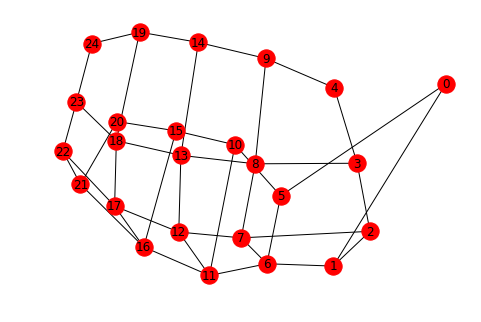

In [233]:
nx.draw(graphs_gt[idx].to_undirected(), with_labels=True)
plt.show()

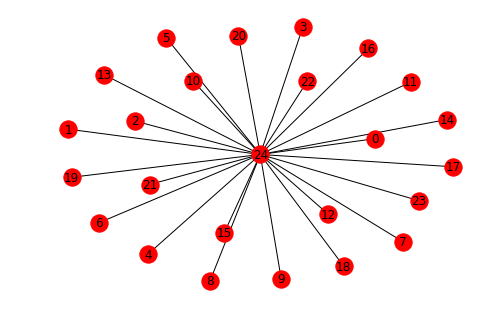

In [234]:
nx.draw(graphs_gen[idx].to_undirected(), with_labels=True)
plt.show()

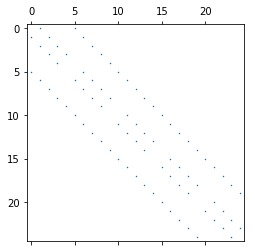

In [227]:
_i_gt = d_gt[idx] + d_gt[idx].T 
_i_gt[_i_gt > 1] = 1
plt.spy(_i_gt, markersize=.5)
plt.show()

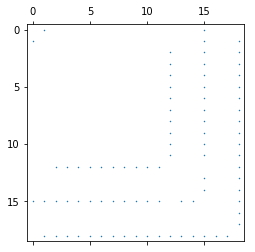

In [228]:
plt.spy(d_b[idx], markersize=.5)
plt.show()

In [278]:
# [d for i,d in graphs_gt[1].in_degree]

In [70]:
countSquare(graphs_gen[idx].to_undirected(), False)

8.0

In [72]:
countSquare(graphs_gt[idx].to_undirected(), False)

16.0

In [71]:
countSquare(graphs_gt[idx], True)

0.0

In [68]:
countTriangle(graphs_gen[idx].to_undirected(), False)

0.0

In [146]:
print("Degree assortativity stats g-t: ", statistics_degree_assortativity([g for g in graphs_gt[:100]]))

Degree assortativity stats g-t:  -0.17466375907587003


In [ ]:
statistics_square_count_both(graphs_gt[:100])

In [ ]:
statistics_triangle_count_both(graphs_gt[:100])

In [ ]:
statistics_degree_assortativity(graphs_gt[:100])

In [235]:
print("Degree stats: ", degree_stats(graphs_gen[:100], graphs_gt[:100]))

Degree stats:  0.09287055667962685


In [236]:
print("Clustering stats: ", clustering_stats(graphs_gen[:100], graphs_gt[:100]))

Clustering stats:  0.060099072906640405


In [139]:
# This was for 25N grid with balanced node flows!!
print("Square counts g-t (d,u): ", statistics_square_count_both(graphs_gt[:100]))

Square counts g-t (d,u):  (0.0, 15.98)


In [151]:
print(filename_b)
shuffle(graphs_gt)
shuffle(graphs_gen)

# print("Triangle counts g-t (d,u): ", statistics_triangle_count_both(graphs_gt[:100]))
# print("Triangle counts baseline (d,u): ", statistics_triangle_count_both(graphs_gen[:100]))
# print("Square counts g-t (d,u): ", statistics_square_count_both(graphs_gt[:100]))
# print("Square counts baseline (d,u): ", statistics_square_count_both(graphs_gen[:100]))
print("Degree assortativity stats g-t: ", statistics_degree_assortativity(graphs_gt[:100]))
print("Degree assortativity stats baseline: ", statistics_degree_assortativity(graphs_gen[:100]))

graph_stats = fetch_default_stats_dict() # OrderedDict()
graph_stats['clustering_stats'] = clustering_stats(graphs_gen[:100], graphs_gt[:100])
print("Clustering stats: ", graph_stats['clustering_stats'])
graph_stats['degree_stats'] = degree_stats(graphs_gen[:100], graphs_gt[:100])
print("Degree stats: ", graph_stats['degree_stats'])
graph_stats['in_degree_stats'], graph_stats['out_degree_stats']  = directed_degree_stats(graphs_gen[:100], graphs_gt[:100])
print("Directed degree stats: in, out", graph_stats['in_degree_stats'], graph_stats['out_degree_stats'])
graph_stats['degree_assort_stats'] = statistics_degree_assortativity(graphs_gen[:100])
print("Degree assortativity stats: ", graph_stats['degree_assort_stats'])
graph_stats['edge_flow_stats'] = edge_flow_dist_stats(graphs_gt[:100], graphs_gen[:100], bins='auto')
print("Edge flow distribution stats: ", graph_stats['edge_flow_stats'])
graph_stats['node_flow_stats'] = node_flow_dist_stats(graphs_gt[:100], graphs_gen[:100], bins='auto')
print("Node flow distribution stats: ", graph_stats['node_flow_stats'])
# graph_stats['d_triangle_count'], graph_stats['u_triangle_count'] = statistics_triangle_count_both(graphs_gen[:100])
# print("Triangle counts undirected: , ", graph_stats['u_triangle_count'])
# print("Triangle counts directed: ", graph_stats['d_triangle_count'])
# graph_stats['d_square_count'], graph_stats['u_square_count'] = statistics_square_count_both(graphs_gen[:100])
# print("Square counts undirected: ", graph_stats['u_square_count'])
# print("Square counts directed: ", graph_stats['d_square_count'])
print("Average degree g-t: ", np.average([np.count_nonzero(d+d.T, axis=0) for d in d_gt[:100]]))
print("Average degree baseline: ", np.average([np.count_nonzero(d, axis=0) for d in d_b[:100]]))

../../netgan/output/netgan_nyc_taxi_18.pickle
Degree assortativity stats g-t:  -0.07174167066496243
Degree assortativity stats baseline:  -0.059044999869237745
Clustering stats:  0.020190218510336273
Degree stats:  0.06023658131283072
Directed degree stats: in, out 0.007902184009313196 0.07718482954934536
Degree assortativity stats:  -0.059044999869237745
Edge flow distribution stats:  0.5484799247359919
Node flow distribution stats:  0.3754663019673006
Average degree g-t:  8.85875
Average degree baseline:  6.75


In [309]:
print("Degree assortativity stats g-t: ", statistics_degree_assortativity(graphs_gt[200:220]))

Degree assortativity stats g-t:  -0.17719935274448478


In [139]:
degree_stats(graphs_gen[:10], graphs_gt[10:20])

0.24708106626562198

#### Collect results down here (E-R & B-A)

1. E-R-Taxi-8:
Triangle counts g-t (d,u):  (10.06, 263.6)
Triangle counts baseline (d,u):  (226.86, 113.43)
Square counts g-t (d,u):  (16.25, 1886.9)
Square counts baseline (d,u):  (1499.1, 749.55)
Degree assortativity stats g-t:  -0.17261889496293448
Degree assortativity stats baseline:  -0.07299747870910506
Clustering stats:  0.019725735416844112
Degree stats:  0.08855503259853315
Directed degree stats: in, out 0.21610588070091508 0.023738475903718248
Edge flow distribution stats:  nan
Node flow distribution stats:  0.509113365505419
Average degree g-t:  7.048125
Average degree baseline:  6.93

2. B-A-Taxi-8:
Triangle counts g-t (d,u):  (10.66, 284.94)
Triangle counts baseline (d,u):  (240.54, 120.27)
Square counts g-t (d,u):  (17.15, 2103.62)
Square counts baseline (d,u):  (1542.12, 771.06)
Degree assortativity stats g-t:  -0.17261889496293448
Degree assortativity stats baseline:  -0.19545334356159927
Clustering stats:  0.020249908918675858
Degree stats:  0.06807261462241865
Directed degree stats: in, out 0.07123970066646002 0.029010772035519272
Degree assortativity stats:  -0.19545334356159927
Edge flow distribution stats:  nan
Node flow distribution stats:  0.5125071707701023
Average degree g-t:  7.048125
Average degree baseline:  6.5225


3. E-R-Taxi-13:
Triangle counts g-t (d,u):  (38.26, 180.95)
Triangle counts baseline (d,u):  (114.44, 57.22)
Square counts g-t (d,u):  (108.43, 1045.07)
Square counts baseline (d,u):  (605.62, 302.81)
Degree assortativity stats g-t:  -0.0436539882614747
Degree assortativity stats baseline:  -0.08039475269066687
Clustering stats:  0.020673574875343485
Degree stats:  0.11500212547590238
Directed degree stats: in, out 0.0803469655202329 0.04539784773151956
Degree assortativity stats:  -0.08039475269066687
Edge flow distribution stats:  nan
Node flow distribution stats:  0.5226786049429493
Average degree g-t:  6.06625
Average degree baseline:  6.12125

4. B-A-Taxi-13:
Triangle counts g-t (d,u):  (36.22, 173.3)
Triangle counts baseline (d,u):  (145.66, 72.83)
Square counts g-t (d,u):  (100.31, 985.0)
Square counts baseline (d,u):  (754.86, 377.43)
Degree assortativity stats g-t:  -0.0456767388994398
Degree assortativity stats baseline:  -0.21689627243675047
Clustering stats:  0.020640978403315142
Degree stats:  0.11630834137011026
Directed degree stats: in, out 0.026417025842959685 0.05058843238514554
Degree assortativity stats:  -0.21689627243675047
Edge flow distribution stats:  nan
Node flow distribution stats:  0.5101451732795237
Average degree g-t:  6.06625
Average degree baseline:  5.291875

5. E-R-Taxi-18:
Triangle counts g-t (d,u):  (36.67, 358.71)
Triangle counts baseline (d,u):  (346.28, 173.14)
Square counts g-t (d,u):  (101.96, 2707.59)
Square counts baseline (d,u):  (2554.04, 1277.02)
Degree assortativity stats g-t:  -0.06250343360997467
Degree assortativity stats baseline:  -0.06364278705422502
Clustering stats:  0.020110194914439827
Degree stats:  0.09210099744796896
Directed degree stats: in, out 0.03306128005579012 0.12335671354445976
Degree assortativity stats:  -0.06364278705422502
Edge flow distribution stats:  nan
Node flow distribution stats:  0.37764714556831214
Average degree g-t:  8.85875
Average degree baseline:  8.893125

6. B-A-Taxi-18:
Triangle counts g-t (d,u):  (37.59, 362.47)
Triangle counts baseline (d,u):  (394.92, 197.46)
Square counts g-t (d,u):  (105.7, 2754.93)
Square counts baseline (d,u):  (2920.7, 1460.35)
Degree assortativity stats g-t:  -0.06009197884922079
Degree assortativity stats baseline:  -0.18640021963869427
Clustering stats:  0.020078625921353902
Degree stats:  0.06112519560249652
Directed degree stats: in, out 0.03459739409526552 0.031537453826322004
Degree assortativity stats:  -0.18640021963869427
Edge flow distribution stats:  nan
Node flow distribution stats:  0.3824532612586784
Average degree g-t:  8.85875
Average degree baseline:  8.175


7. E-R-Grid-25N:
../../GraphRNN/output/e-r_grid_25N.pickle
Triangle counts g-t (d,u):  (0.0, 0.0)
Triangle counts baseline (d,u):  (11.06, 5.53)
Square counts g-t (d,u):  (0.0, 15.99)
Square counts baseline (d,u):  (25.88, 12.94)
Degree assortativity stats g-t:  -0.17512509543457383
Degree assortativity stats baseline:  -0.10116417719303888
Clustering stats:  0.9217941117892309
Degree stats:  0.1329920238501776
Directed degree stats: in, out 0.11275572424062519 0.10589468903989552
Degree assortativity stats:  -0.10116417719303888
Edge flow distribution stats:  nan
Node flow distribution stats:  0.37395204431155227
Average degree g-t:  3.1984
Average degree baseline:  3.1768

8. B-A-Grid-25N:
../../GraphRNN/output/b-a_grid_25N.pickle
Triangle counts g-t (d,u):  (0.0, 0.0)
Triangle counts baseline (d,u):  (0.0, 0.0)
Square counts g-t (d,u):  (0.0, 15.98)
Square counts baseline (d,u):  (0.0, 0.0)
Degree assortativity stats g-t:  -0.14152817828485464
Degree assortativity stats baseline:  -0.38797386426768915
Clustering stats:  0.0
Degree stats:  0.47033489541064166
Directed degree stats: in, out 0.41111620674742944 0.4094465432182708
Degree assortativity stats:  -0.38797386426768915
Edge flow distribution stats:  nan
Node flow distribution stats:  0.37415820028850133
Average degree g-t:  3.1984
Average degree baseline:  1.92

9. E-R-Barbell-20N:
../../GraphRNN/output/e-r_barbell_20N.pickle
Triangle counts g-t (d,u):  (0.02, 39.29)
Triangle counts baseline (d,u):  (35.0, 17.5)
Square counts g-t (d,u):  (0.01, 113.05)
Square counts baseline (d,u):  (115.92, 57.96)
Degree assortativity stats g-t:  -0.0653597878051939
Degree assortativity stats baseline:  -0.1313155860214049
Clustering stats:  0.025083409032922502
Degree stats:  0.024950060239157468
Directed degree stats: in, out 0.025602909427964393 0.03668447421411192
Degree assortativity stats:  -0.1313155860214049
Edge flow distribution stats:  nan
Node flow distribution stats:  0.3670588201416085
Average degree g-t:  4.661
Average degree baseline:  4.515

10. B-A-Barbell-20N:
../../GraphRNN/output/b-a_barbell_20N.pickle
Triangle counts g-t (d,u):  (0.02, 36.2)
Triangle counts baseline (d,u):  (26.64, 13.32)
Square counts g-t (d,u):  (0.0, 102.34)
Square counts baseline (d,u):  (77.64, 38.82)
Degree assortativity stats g-t:  -0.05610178667655418
Degree assortativity stats baseline:  -0.3221427958472464
Clustering stats:  0.046204137540987185
Degree stats:  0.1017056086557302
Directed degree stats: in, out 0.15333068015546258 0.15389975665840328
Degree assortativity stats:  -0.3221427958472464
Edge flow distribution stats:  nan
Node flow distribution stats:  0.3669595444063276
Average degree g-t:  4.661
Average degree baseline:  3.786


#### Collect results down here (NetGAN)

1. Netgan-Grid-25N:
Triangle counts g-t (d,u):  (0.0, 0.0)
Triangle counts baseline (d,u):  (0.42, 0.21)
Square counts g-t (d,u):  (0.0, 15.99)
Square counts baseline (d,u):  (15.68, 7.84)
Degree assortativity stats g-t:  -0.16931048709297764
Degree assortativity stats baseline:  0.16196093278430254
Clustering stats:  0.013567753717415254
Degree stats:  0.06097952333891565
Directed degree stats: in, out 0.2680262711245789 0.24794573996555003
Degree assortativity stats:  0.1646990854271598
Edge flow distribution stats:  0.3606385907986758
Node flow distribution stats:  0.3744833612859795
Average degree g-t:  3.1984
Average degree baseline:  2.72


3. Netgan-Barbell-20N-sparse:
../../netgan/output/netgan_barbell_20N_sparse.pickle
Triangle counts g-t (d,u):  (0.11, 35.19)
Triangle counts baseline (d,u):  (44.42, 22.21)
Square counts g-t (d,u):  (0.05, 97.69)
Square counts baseline (d,u):  (112.8, 56.4)
Degree assortativity stats g-t:  -0.057753348067305345
Degree assortativity stats baseline:  -0.1381064549777965
Clustering stats:  0.022285783627694525
Degree stats:  0.02036860463474932
Directed degree stats: in, out 0.017356405260758434 0.013204844864348697
Degree assortativity stats:  -0.1381064549777965
Edge flow distribution stats:  0.21920057269479742
Node flow distribution stats:  0.3669965807836053
Average degree g-t:  4.661
Average degree baseline:  4.4




4. Netgan-Barbell-20N-dense:
../../netgan/output/netgan_barbell_20N.pickle
Triangle counts g-t (d,u):  (36.56, 141.16)
Triangle counts baseline (d,u):  (129.86, 64.93)
Square counts g-t (d,u):  (78.35, 599.93)
Square counts baseline (d,u):  (429.12, 214.56)
Degree assortativity stats g-t:  0.11254332881482788
Degree assortativity stats baseline:  -0.13151266825451668
Clustering stats:  0.044696435016720285
Degree stats:  0.27214603150519223
Directed degree stats: in, out 0.015666267470234807 0.013012639046202201
Degree assortativity stats:  -0.13151266825451668
Edge flow distribution stats:  0.40144168493656274
Node flow distribution stats:  0.3808078137964719
Average degree g-t:  7.08
Average degree baseline:  6.0


5. Netgan-Taxi-8:
../../netgan/output/netgan_nyc_taxi_8.pickle
Triangle counts g-t (d,u):  (11.83, 277.93)
Triangle counts baseline (d,u):  (175.7, 87.85)
Square counts g-t (d,u):  (19.99, 2028.79)
Square counts baseline (d,u):  (841.2, 420.6)
Degree assortativity stats g-t:  -0.17897787760287243
Degree assortativity stats baseline:  -0.22387231447497097
Clustering stats:  0.02027532257792417
Degree stats:  0.0365096487727361
Directed degree stats: in, out 0.13113853612713844 0.027769004930476182
Degree assortativity stats:  -0.22387231447497097
Edge flow distribution stats:  0.6364418299604782
Node flow distribution stats:  0.5148433725835502
Average degree g-t:  7.048125
Average degree baseline:  6.5


6. Netgan-Taxi-13:
../../netgan/output/netgan_nyc_taxi_13.pickle
Triangle counts g-t (d,u):  (37.94, 179.04)
Triangle counts baseline (d,u):  (265.3, 132.65)
Square counts g-t (d,u):  (105.3, 1022.2)
Square counts baseline (d,u):  (1387.98, 693.99)
Degree assortativity stats g-t:  -0.03699877083716355
Degree assortativity stats baseline:  -0.05992943676418506
Clustering stats:  0.02015471212194907
Degree stats:  0.026865126583554
Directed degree stats: in, out 0.0336577550990842 0.035319904638062116
Degree assortativity stats:  -0.05992943676418506
Edge flow distribution stats:  0.4722035558511182
Node flow distribution stats:  0.5232194713175422
Average degree g-t:  6.06625
Average degree baseline:  7.0


7. Netgan-Taxi-18:
../../netgan/output/netgan_nyc_taxi_18.pickle
Triangle counts g-t (d,u):  (36.69, 352.62)
Triangle counts baseline (d,u):  (189.22, 94.61)
Square counts g-t (d,u):  (100.08, 2633.3)
Square counts baseline (d,u):  (880.94, 440.47)
Degree assortativity stats g-t:  -0.058730842936819884
Degree assortativity stats baseline:  -0.07232535023471395
Clustering stats:  0.020178678639026858
Degree stats:  0.06023658131283072
Directed degree stats: in, out 0.011397944251061665 0.06654336380658399
Degree assortativity stats:  -0.07232535023471395
Edge flow distribution stats:  0.544170169725847
Node flow distribution stats:  0.3875938062327451
Average degree g-t:  8.85875
Average degree baseline:  6.75

In [145]:
G_lobster = nx.generators.random_graphs.random_lobster(10, 0.5, 0.8)

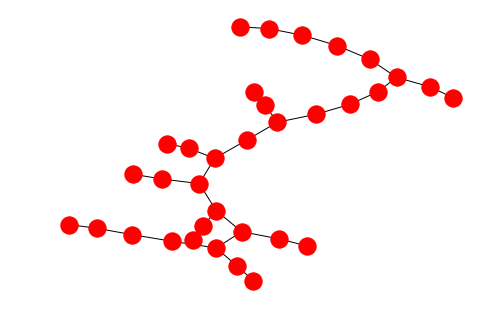

In [146]:
nx.draw(G_lobster)

In [131]:
nx.info(G_lobster)

'Name: \nType: Graph\nNumber of nodes: 18\nNumber of edges: 17\nAverage degree:   1.8889'